## NMR in Python

### Why? 

NMR analysis is still a very manual process. From peak picking to generating figures, there's a lot of opportunity to reuse functions or gather data for future ML/AI applications. However, unlike MS analysis, there aren't readily available tools for NMR that are accessible via API. 

Using only nmrglue and a few other packages, it is entirely possible to build a classification system to analyze your data and generate plots. 

### Objective: 

To plot and manipulate your NMR data using the NMR glue package. It's not an extremely comprehensive library, but it can read in data from Bruker instruments and some more advanced open source formats (such as sparky and nmrpipe), so it can be very handy to get a hold of the data and learn its structure. 

### Caveats: 
Today we're going to be working with Bruker processed data. JEOL data, unfortunately, is not supported - but other open source formats are. If you have JEOL data, you should export it from DELTA as JCAMP-DX format, which should be compatible with nmrglue. If you are using MNVOA for all your data processing, other options are available for conversion. 

### Let's get the general imports out of the way: 

In [1]:
import nmrglue as ng
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

## Read in your data: 

nmrglue can read in processed data or unprocessed data (from Bruker instruments). It is important to know which one you're dealing with because any phase correction, baseline correction, or other manipulations (referencing) can be consequential down the road. 

The nmrglue reading module provides a dictionary of spectra parameters (shown below as the dic variable) and the actual data (presented in an array). If you're familiar with Bruker formats, then the dic variable should be easy to navigate and get certain values (like the O1 offset)

In [2]:
dic, data = ng.fileio.bruker.read_pdata("nmr_data/Bruker/Erythromycin_Standard/10/pdata/1")

In [3]:
dic['acqus']['O1'] 

6606.72

## Conversion: 

When we convert or manipulate our data in vendor software, we are almost always using PPM as a scale. However, when we think about how these data are actually plotted, it's often through points (not even Hz) where each point is a set amount of distance between them. To get things in a more familiar place, let's convert the points over to ppm_scale

In [4]:
udic = ng.bruker.guess_udic(dic, data)  # needed to convert from points to PPM, this fetches things like the sweep width, number of points, and other parameters
uc = ng.fileiobase.uc_from_udic(udic)
ppm_scale = uc.ppm_scale()

## Plotting: 

Now we're ready to plot the data. To do this, we are going to use matplotlib and our newly converted ppm scale.

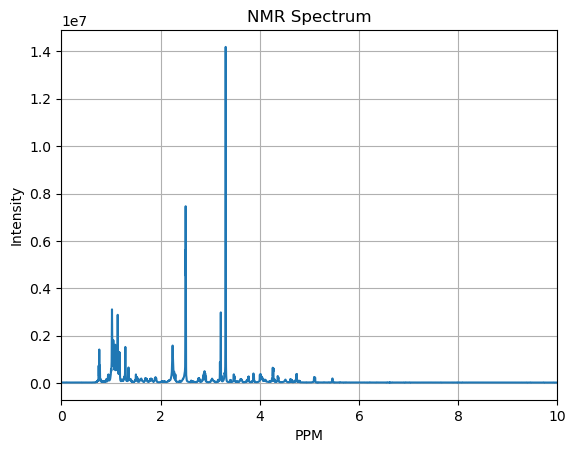

In [5]:
## create the plot and set labels
plt.plot(ppm_scale, data)
plt.xlabel("PPM")
plt.ylabel("Intensity")
plt.title("NMR Spectrum")
plt.xlim(0, 10)  # adjust limits as needed
plt.grid()

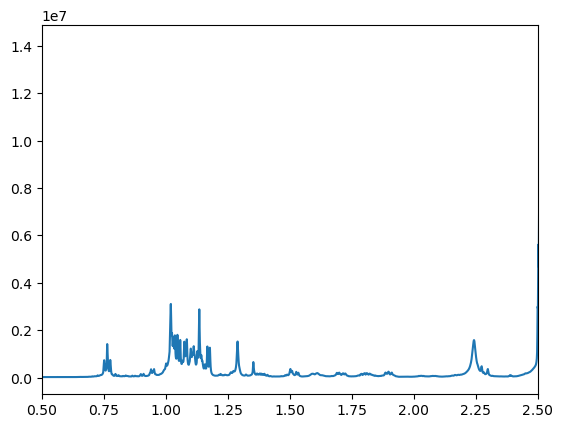

In [6]:
## create a zoom of a specific region
plt.plot(ppm_scale, data)
plt.xlim(0.5, 2.5)  # adjust limits to zoom in on a specific region
plt.show()

### Stackplots

Stackplots are very informative and can make for some great figures. Sometimes, producing the same exact zoom in topspin and adding annotations can be a pain - so lets create our own here. 

Text(0.5, 1.0, 'NMR Spectrum Comparison')

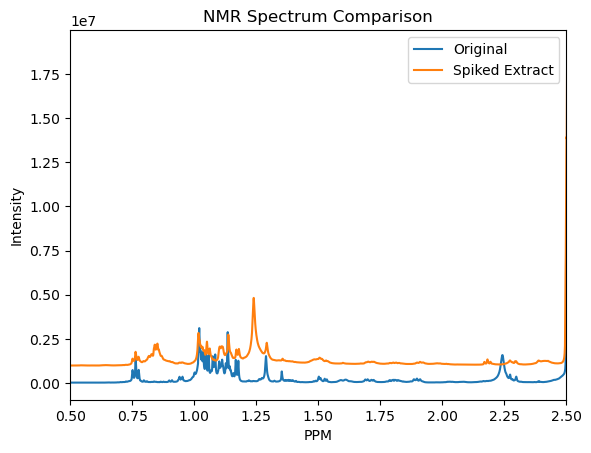

In [7]:
## read in a second NMR 1H file
dic2, data2 = ng.fileio.bruker.read_pdata("nmr_data/Bruker/Spiked_Extract/10/pdata/1")
## convert the data to PPM scale and plot
udic2 = ng.bruker.guess_udic(dic2, data2)   
uc2 = ng.fileiobase.uc_from_udic(udic2)
ppm_scale2 = uc2.ppm_scale()
## create a stacked plot, offset by 1e6 for visibility
plt.plot(ppm_scale, data, label="Original")
plt.plot(ppm_scale2, data2 +1e6, label="Spiked Extract")
plt.legend()
plt.xlim(0.5, 2.5)  # adjust limits to zoom in on a specific region
plt.xlabel("PPM")   
plt.ylabel("Intensity")
plt.title("NMR Spectrum Comparison")

### Peak picking

Multi-dimensional (2D) Peak picking is something that has not yet been optimized for automation - but you can perform your own peak picking on 1D data if you wish through a package called scipy. Better yet, we can add labels to the peak maxima and their values in PPM. 

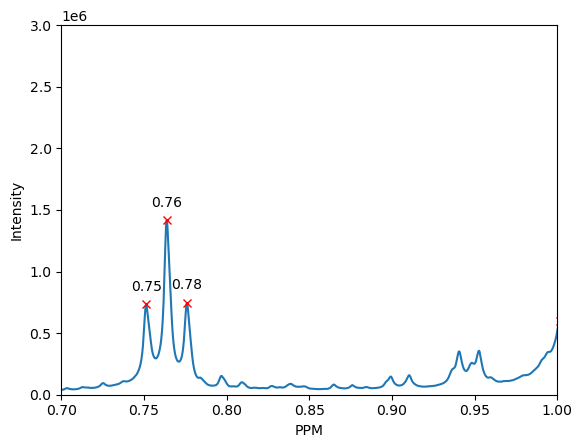

In [8]:
## report peaks 
from scipy.signal import find_peaks
peaks, _ = find_peaks(data, height=5e5)  # adjust height as needed
## convert peak indices to PPM
peak_ppm = ppm_scale[peaks]
## plot the peaks on the spectrum
plt.plot(ppm_scale, data)
plt.plot(peak_ppm, data[peaks], "x", color='red', label='Peaks')
plt.xlim(0.7, 1.0)  # adjust limits to zoom in on a specific region
plt.ylim(0, 3e6)  # adjust y limits for visibility
plt.xlabel("PPM")
plt.ylabel("Intensity")
## label the peaks
for i, peak in enumerate(peak_ppm):
    plt.annotate(f"{peak:.2f}", (peak, data[peaks][i]), textcoords="offset points", xytext=(0,10), ha='center')
## create a table of peaks
peaks_df = pd.DataFrame({
    'PPM': peak_ppm,
    'Intensity': data[peaks]
})

## Beyond figures: 

So here's the most important thing. Once your data are in this kind of a format, you can perform any calculation you wish on them. From automatically reporting peaks in a given region (useful for adulteration studies) or designing an ML model to classify new ingredient lots as pass/fail, or finding new and exciting molecules you do not have in your library - it's all possible from here. 

Below is an example of using these data from our peak picked regions to automatically fetch the coupling constants for this doublet of doublets. 

In [9]:
## calculate the distance between peak maxima to estimate coupling constants
coupling_constants = []
for i in range(len(peaks)-1):
    distance = abs(peak_ppm[i] - peak_ppm[i + 1])
    coupling_constant = distance * 600 # convert PPM to Hz (assuming 600 MHz spectrometer)
    coupling_constants.append(coupling_constant)

# Pad the coupling_constants list to match the length of peaks_df

coupling_constants_padded = coupling_constants + [np.nan]

peaks_df['Coupling Constant (Hz)'] = coupling_constants_padded

# Calculate coupling constant for the last point if there are at least two filtered peaks
if len(peaks_df) >= 2:
    last_ppm = peaks_df.iloc[-1]['PPM']
    prev_ppm = peaks_df.iloc[-2]['PPM']
    last_coupling = abs(last_ppm - prev_ppm) * 600  # 600 MHz spectrometer
    peaks_df.iloc[-1, peaks_df.columns.get_loc('Coupling Constant (Hz)')] = last_coupling

## filter the peaks_df to include only peaks between 0.7 and 1.0 PPM
filtered_peaks_df = peaks_df[(peaks_df['PPM'] >= 0.7) & (peaks_df['PPM'] <= 1.0)].copy()
filtered_peaks_df



,PPM,Intensity,Coupling Constant (Hz)
36,0.775900,7.435770e+05,7.366387
37,0.763622,1.414262e+06,7.366387
38,0.751345,7.326302e+05,7.366387


Text(0.5, 1.0, 'NMR Spectrum with Coupling Constants')

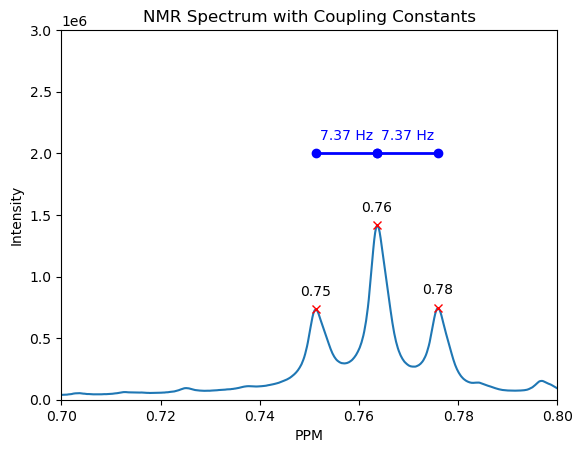

In [10]:
## plot the spectrum as before, but now label the distance between the peaks in their coupling constants we just calculated
plt.plot(ppm_scale, data)
plt.plot(peak_ppm, data[peaks], "x", color='red', label='Peaks')
plt.xlim(0.7, 0.8)  # adjust limits to zoom in on a specific region
plt.ylim(0, 3e6)  # adjust y limits for visibility
plt.xlabel("PPM")
plt.ylabel("Intensity")
## label the peaks
for i, peak in enumerate(peak_ppm):
    plt.annotate(f"{peak:.2f}", (peak, data[peaks][i]), textcoords="offset points", xytext=(0,10), ha='center')
## create a table of peaks

peaks_df = pd.DataFrame({
    'PPM': peak_ppm,
    'Intensity': data[peaks]
})
# Use filtered_peaks_df for coupling constant annotation to avoid index errors
filtered_ppm = filtered_peaks_df['PPM'].values
filtered_intensity = filtered_peaks_df['Intensity'].values
coupling_constants = filtered_peaks_df['Coupling Constant (Hz)'].values
# Draw a line with circles above the peaks, showing coupling constants
y_coupling = 2e6
for i in range(len(filtered_ppm) - 1):
    # Draw a line between the two peaks at y=2e6
    plt.plot([filtered_ppm[i], filtered_ppm[i + 1]], [y_coupling, y_coupling], color='blue', linewidth=2)
    # Draw circles at each peak position
    plt.plot(filtered_ppm[i], y_coupling, 'o', color='blue')
    plt.plot(filtered_ppm[i + 1], y_coupling, 'o', color='blue')
    # Annotate the coupling constant above the line
    plt.annotate(f"{coupling_constants[i]:.2f} Hz",
                 ((filtered_ppm[i] + filtered_ppm[i + 1]) / 2, y_coupling),
                 textcoords="offset points", xytext=(0,10), ha='center', color='blue')
plt.title("NMR Spectrum with Coupling Constants")


## Summary: 

nmrglue is only one package that can read in data, but it is possible to see how automatic processing can be very powerful. There are other packages that allow you to directly manipulate data from other formats, such as PyMETAflow (for MNOVA users) or ProtoMix for high throughput metabolomics work. 

In general, NMR needs more resources such as spectral databases that can be interacted with via APIs - or a way to find literature reported values in your solvent. With those, library matching 1D spectra would be VERY easy to do programmatically. 

### Extra: A topspin python example: 
From www.madbytenmr.com/madbyte-blog?category=Automation by Joseph Egan.

Topspin also has a python module built in which allows you to perform all the zero-filling, linear prediction, phase correction, and more in a unified way across hundreds of spectra. 

This blog has several tips and tricks you won't find easily in the manual, but it's just a starting point. 

Topspin has built in functions already, but thery're not really well documented. You'll see below MSG (a function to generate a message box to the user) and GETPAR (a function that gets parameters similar to what nmrglue does with the dic variable).



In [ ]:
# Now let's do some automatic processing of 2D NMR data in topspin.
### THIS WILL NOT WORK IN A JUPYTER NOTEBOOK, IT IS A TOPSPIN PYTHON SCRIPT ONLY ###

#We're going to fetch the TD value and use this as the baseline for setting SI and LPBIN
TD1 = GETPAR('TD',axis=1)
TD2 = GETPAR('TD',axis=2)
MSG('TD for Axis F1 is '+TD1+' and F2 is '+TD2)
SI1 = GETPAR('SI',axis=1)
SI2 = GETPAR('SI',axis=2)
MSG('The SI for F1 is '+str(SI1)+ ' and F2 is '+ str(SI2))

#We want to do some zero filling and linear prediction. So, we need to adjust SI to allow for that. 
#Following recommendations on this, we want to set SI to be 2*TD to start. 

SI_New_1 = int(TD1)*2
SI_New_2 = int(TD2)*2
MSG('The new SI Values should be '+str(SI_New_1)+ ' and ' +str(SI_New_2))

# Now set those values

PUTPAR('1 SI', str(SI_New_1))
PUTPAR('2 SI', str(SI_New_2))

MSG('The new values have been set. SI for F1 and F2 are now ' +str(SI_New_1) + ' and ' +str(SI_New_2))

PUTPAR('1 ME_mod','LPfr')
PUTPAR('2 ME_mod','LPfr')

LPBIN_Val_1 = int(TD1)*1.5
LPBIN_Val_2 = int(TD2)*1.5
PUTPAR('1 LPBIN',str(LPBIN_Val_1))
PUTPAR('2 LPBIN',str(LPBIN_Val_2))
MSG('The values of LPBIN have been set to '+str(LPBIN_Val_1)+' and '+str(LPBIN_Val_2))

#XCMD('xfb')
#or
XFB()

#PP()           # Opens the PP dialog box
PP('silent')   # Performs automatic peak picking, no dialog box. 

